In [4]:
import numpy as np
import matplotlib.pyplot as plot
import matplotlib.image

w_scaling_factor = 15
sub_dp = 19  # nums of col for hotness - 1


class HeatmapHeuristic:
    """
    encapsulate heuristic logic

    it generates heatmap using two steps
    first step: analyze csv to collect stats
    second step: generate heatmap

    """

    def __init__(self, memregion_size: int, time_resolution: float) -> None:
        """
        constructor to define metadata like 
        what will be the memory region of analysis granularity
        what will the time granularity


        """
        assert time_resolution >= 0.5, "time resolution less than 0.5s is not considered"
        self.memregion_size = memregion_size
        self.time_resolution = time_resolution

        self.address_dict = {}
        self.address_timeline_dict = {}
        self.address_reversechange_dict = {}
        self.min_address = 1e30
        self.max_address = 0
        self.min_time = 1e30
        self.max_time = 0

        self.address_list = []
        self.time_list = []
        self.heat_stat_list = []

    def data_point_collect(self, csv_filepath: str) -> None:
        """
        analyze each line of the file and store necessary data
        first part of the heuristic

        Input:
        csv_filepath: path of the csv file
        """
        # reset the stats
        self.address_dict = {}
        self.address_timeline_dict = {}
        self.address_reversechange_dict = {}
        self.min_address = 1e30
        self.max_address = 0
        self.min_time = 1e30
        self.max_time = 0

        with open(csv_filepath) as fin:
            for line in fin.readlines():
                tokens = line.split('\t')

                address = int(tokens[1])
                if address not in self.address_dict:
                    self.address_dict[address] = {}
                    self.address_reversechange_dict[address] = {}
                    self.address_timeline_dict[address] = []

                    self.address_list.append(address)

                # calculate the refcnt_diff_list
                # to calculate hotness later
                time_val = int(float(tokens[0])/self.time_resolution)
                if time_val not in self.address_dict[address]:
                    self.address_dict[address][time_val] = 0
                    self.address_reversechange_dict[address][time_val] = 0

                if time_val not in self.time_list:
                    self.time_list.append(time_val)

                # first column of trace is not used which is index 3
                # last slow trace column is also not used
                refcnt_diff_list = [int(i) for i in tokens[2:]]
                refcnt_change_evt_count = 0
                for j in range(0, len(refcnt_diff_list) - 1):
                    # TODO
                    # different weighting based on what is the absolute value of ref count
                    # refcnt_change_evt_count += 1 if refcnt_diff_list[j] > 0 else 0
                    refcnt_change_evt_count += 1 if abs(
                        refcnt_diff_list[j] - refcnt_diff_list[j-1]) > 0 else 0
                # thinking is, if an object has many refernce change it means it is getting passed around
                # why pass around? => to access is the likely reason
                # if refcnt_change_evt_count == 0:
                #     print("There is a record that has no change at all")
                #     print(line)
                self.heat_stat_list.append(refcnt_change_evt_count)
                self.address_dict[address][time_val] += refcnt_change_evt_count
                # number of column - 1 + refcnt change event
                # the logic is if an object is long standing, it may be type of global object
                # and if it is long standing it may be the case that it is getting accessed always
                # but also maybe the case it is just cached for future use
                #
                # so what to do, unfortunately with reference count we can not have any more information
                # so we will increase the weight but slowly
                # TODO
                # check 79 and 89, combination of both at line 131 should make all pixel of same value, that's not happening, why?
                self.address_reversechange_dict[address][time_val] += sub_dp - \
                    refcnt_change_evt_count
                # add the time to address timeline
                self.address_timeline_dict[address].append(time_val)

                # min-max resolve
                if address < self.min_address:
                    self.min_address = address
                if address >= self.max_address:
                    self.max_address = address
                if time_val < self.min_time:
                    self.min_time = time_val
                if time_val >= self.max_time:
                    self.max_time = time_val

            self.address_list.sort()
            self.time_list.sort()
            self.heat_stat_list.sort()
            print("Minimum data point heat")
            print(self.heat_stat_list[0])
            # print(len(list(self.address_dict.keys())))
            # for address in self.address_timeline_dict:
            #    print(self.address_timeline_dict[address])
            # print(len(self.address_list))
            # print(len(self.time_list))
            # print(self.address_list[-1]-self.address_list[0])

    def heuristic(self, timeweight=False) -> np.ndarray:
        """
        second step of heuristic to generate a heatmap

        this step travarse through each address (one row of image) 
        and corresoinding rows each pixel (one time step) to draw heatmap
        """
        img_w = self.max_time-self.min_time + 1
        img_h = (self.max_address-self.min_address)//self.memregion_size + 1
        print("region image dimension: {0}x{1}".format(
            self.max_time-self.min_time, (self.max_address-self.min_address)//self.memregion_size))

        # img_array = np.full((img_h, img_w*w_scaling_factor), fill_value=0.0)
        img_array = np.full((img_h, img_w*w_scaling_factor),
                            fill_value=0, dtype=np.int32)
        print("image shape:")
        print(img_array.shape)

        debug_switch = False
        changed_pixel = []

        pixel_time_weight = {}

        for address in self.address_dict:
            # print("Start analyzing for address:")
            # print(address)
            # why this img_h -
            # because opencv start (0,0) at upper left corner not lower left
            # (img_h - (address - self.min_address))//self.memregion_size
            y = (address - self.min_address)//self.memregion_size
            # if (y==400):
            #    print("spot sussy datapoint address")
            #    print(address)
            timeline_dict = self.address_dict[address]
            # address_sampling_times = self.address_timeline_dict[address]

            # each pixel is the heat of address (y+min_address)==address 's heat at timestep i equivalent to time x+self.min_time
            # assuming initial no heat
            # existing_heat = 0
            for x in range(img_w):
                # if (y==400 and x==50):
                #    print("spot sussy datapoint")
                timeval = x + self.min_time
                # if timeval in timeline_dict it means the time was sampled by bookkeeping
                if timeval in timeline_dict:
                    # try:
                    img_array[y, x *
                              w_scaling_factor] = timeline_dict[timeval]  # (timeline_dict[timeval] +\
                    if y in pixel_time_weight:
                        if x in pixel_time_weight[y]:
                            pixel_time_weight[y][x] += 1
                        else:
                            pixel_time_weight[y][x] = 1
                    else:
                        pixel_time_weight[y] = {}
                        pixel_time_weight[y][x] = 1
                    # 0 if not timeweight or timeval<max(address_sampling_times) else self.address_reversechange_dict[address][timeval])
                    # existing_heat = img_array[y, x]
                    if (y == 400 and debug_switch):
                        # debug_switch = False
                        print("Sussy datapoint gets populated first")
                        print(x)
                        print(img_array[y, x])
                        # print(existing_heat)
                        # print(timeline_dict)
                        print("Sussy datapoint check:")
                        print(img_array[400, 8])
                    # except Exception as e:
                    #    pass
                # if not we have no way of knowing heat (unless we estimate based on some model)
                # here the model is heat will stay same
                else:
                    pass
                    # TODO
                    # commenting out following line should make the image kind of same (with intermittent gap), that's not the case why?
                    # this is not making sense also the image without this line is better (with intermittent gap)
                    # if (y==400 and x==50 and debug_switch):
                    #    debug_switch = False
                    #    print("Sussy datapoint gets nulled first")
                    #    print(x)
                    #    print(img_array[y,x])
                    #    print(existing_heat)
                    #    print(timeline_dict)
                    # img_array[y, x] = 0#existing_heat
                changed_pixel.append((y, x))

        # for y in pixel_time_weight:
        #    for x in pixel_time_weight[y]:
        #        img_array[y, x] = img_array[y, x] / pixel_time_weight[y][x]

        for y in range(img_h):
            last_time_heat = 0
            remaining_approximation_window = 0
            approximation_pace = 100
            for x in range(img_w*w_scaling_factor):
                if img_array[y, img_w*w_scaling_factor - x - 1] != 0:
                    last_time_heat = img_array[y,
                                               img_w*w_scaling_factor - x - 1]
                    remaining_approximation_window = sub_dp * approximation_pace
                    continue
                else:
                    if remaining_approximation_window != 0:
                        # print("hey")
                        # print(remaining_approximation_window)
                        img_array[y, img_w*w_scaling_factor -
                                  x - 1] = last_time_heat
                        remaining_approximation_window -= 1
                    else:
                        continue

        print("Sussy datapoint check:")
        print(img_array[400, 8])

        # img_array /= 18.0
        # img_array *= 100

        # print(img_array.min())

        # img_array = 100 - img_array
        # for pixel in changed_pixel:
        #    img_array[pixel[0], pixel[1]] = 255 - img_array[pixel[0], pixel[1]]

        return np.asarray(img_array, dtype=np.uint8)

    def get_hot_address(self, mode="EVER_HOT"):
        heat_stat_list_threshold_revs_index = len(self.heat_stat_list)//100
        heat_threshold = self.heat_stat_list[len(
            self.heat_stat_list)-heat_stat_list_threshold_revs_index]
        hot_address_list = []
        if mode == "EVER_HOT":
            for address in self.address_dict:
                for time in self.address_dict[address]:
                    if self.address_dict[address][time] >= heat_threshold:
                        hot_address_list.append(address)
                        break

        elif mode == "TIME_HOT":
            for address in self.address_dict:
                curr_timeline_list = self.address_timeline_dict[address]
                curr_timeline_list.sort()
                for i in range(len(curr_timeline_list)):
                    if self.address_dict[address][curr_timeline_list[i]] >= heat_threshold:
                        if i != len(curr_timeline_list)-1:
                            hot_address_list.append(
                                (address, curr_timeline_list[i], curr_timeline_list[i+1]))
                        else:
                            hot_address_list.append(
                                (address, curr_timeline_list[i], self.max_time))
                        break

        return hot_address_list

    def generate_heatmap(self, csv_filepath: str, img_filepath: str = None, save_image: bool = False) -> None:
        """
        generate heatmap by running two parts of heuristic
        1. analyze
        2. generate heatmap

        Input
        csv_filepath: the path of csv
        imgfile_path: where to save iamge
        save_image: False by default if false will show as pyplot otherwise save iamge
        """
        # analyze, first part of heuristic
        self.data_point_collect(csv_filepath=csv_filepath)

        # generate heatmap which uses 2nd part of heuristic
        img_array = self.heuristic(timeweight=True)

        print(len(self.get_hot_address("TIME_HOT")))

        plot.imshow(img_array)
        cbar = plot.colorbar()
        cbar.ax.set_position([0.76, 0.2, 0.03, 0.6])
        # plot.set_cmap('tab20c')
        plot.set_cmap('inferno')
        plot.gca().invert_yaxis()
        # plot.yticks([0, 100, 200, 300, 400, 500, 600, 700], [
        #             "0", "6", "13", "19", "25", "31", "38", "44"])
        plot.ylabel("Address (MB)")
        # plot.xticks([0, 10*w_scaling_factor, 20*w_scaling_factor, 30*w_scaling_factor, 40*w_scaling_factor, 50 *
        #             w_scaling_factor, 60*w_scaling_factor, 70*w_scaling_factor], ["0", "10", "20", "30", "40", "50", "60", "70"])
        plot.xlabel("Time (s)")
        plot.show()
        # plot.savefig(img_filepath)
        # cv2.imwrite(img_filepath, img_array)
        # matplotlib.image.imsave('heat.png', img_array)
        # input("Enter something adn then press enter to close")


MEMREGION_RES = 256*256  # 1MiB, unit of tracked region, or unit of data to move
TIME_RES = 1  # currently unused we are doing stuff at second resolution

In [5]:
# if __name__ == "__main__":
#     # not using panda because slow for large csv
#     # df = pd.read_csv("matmul_diff.csv")
heatmapGen = HeatmapHeuristic(
    memregion_size=MEMREGION_RES, time_resolution=TIME_RES)

Minimum data point heat
1
region image dimension: 42x15661
image shape:
(15662, 645)
Sussy datapoint check:
6
280389


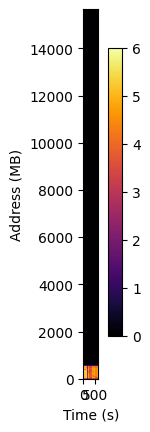

In [6]:
heatmapGen.generate_heatmap(
    csv_filepath="../obj_dump_sorted.txt", img_filepath="heat.png", save_image=False)